In [1]:
#导入依赖包
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.spatial.distance import pdist, squareform

In [2]:
#导入所有数据，比赛中由于有训练赛的存在，可以先导入data2文件夹中200天基金数据，做快速检验
#data1文件夹放的是复赛的数据，data2文件夹放的是初赛的数据
PATH='data1'
trading_date=pd.read_csv(PATH+'/trading_date.csv',header=None)

train_correlation=pd.read_csv(PATH+'/train_correlation.csv',index_col=0)
train_fund_benchmark_return=pd.read_csv(PATH+'/train_fund_benchmark_return.csv',index_col=0)
train_fund_return=pd.read_csv(PATH+'/train_fund_return.csv',index_col=0)
train_index_return=pd.read_csv(PATH+'/train_index_return.csv',encoding='gbk',index_col=0)

test_correlation=pd.read_csv(PATH+'/test_correlation.csv',index_col=0)
test_fund_benchmark_return=pd.read_csv(PATH+'/test_fund_benchmark_return.csv',index_col=0)
test_fund_return=pd.read_csv(PATH+'/test_fund_return.csv',index_col=0)
test_index_return=pd.read_csv(PATH+'/test_index_return.csv',encoding='gbk',index_col=0)
#合并train和test文件
test_correlation=pd.concat([train_correlation.iloc[:,-100:],test_correlation],axis=1)
test_fund_benchmark_return=pd.concat([train_fund_benchmark_return.iloc[:,-100:],test_fund_benchmark_return],axis=1)
test_fund_return=pd.concat([train_fund_return.iloc[:,-100:],test_fund_return],axis=1)
test_index_return=pd.concat([train_index_return.iloc[:,-100:],test_index_return],axis=1)

In [3]:
# #根据缺少的假期补全，保证每周有5天交易日，方便提取每周特征，但是没有提升
# for i in pd.date_range('2015-09-30','2017-12-14'):
#     if str(i.date()) not in test_correlation.columns and i.weekday()<5:
#         test_correlation[i.date().isoformat()]=np.nan
# test_correlation=test_correlation[sorted(test_correlation.columns.tolist())]
# test_correlation=test_correlation.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

In [4]:
# test_index_return=test_index_return.iloc[[0,2,4,17,18,19,21,22,25,26,-8,-7,-6,-5,-3,-2,-1],:]
#筛选出沪深300、中证全债和商品指数3个重要指数
test_index_return=test_index_return.iloc[[0,-7,-1],:]

In [5]:
test_index_return.shape

(3, 300)

In [6]:
#utility
def cal_error(l1,l2):
	np.abs(l1-l2)
def c_indexs(d,df,indexs): 
    d={}
    for i in indexs:
        for j in indexs:
            d['%s-%s' % (i,j)]=np.abs(df.loc[i,:]-df.loc[j,:])
    return d

def select_df(start,len):
	return df.loc[:,start:].iloc[:,:len]

def generate_dateset(dfs,static_indexs):
    r=dfs[0]
    for df in dfs[1:]:
#         use index merge data
        pass
    # add static_indexs
    return r

#给定窗口的df的相关系数
#这个还有更简单的代码，但是为了保证万一产生的误差，提交的这版本就没用到c_indexs_corr_
def c_indexs_corr(df,windows=[3,7,15,30,61]):
    l=[]
    for w in windows:
        for m in ['pearson']:#, 'spearman']:
            tmp=df.iloc[:,-w:].copy()
            co=tmp.T.corr(method=m)
            d={}
            for i in co.index:
                for j in co.columns:
                    d['%s-%s' % (i,j)]=co.loc[i,j]
            d=pd.Series(d)
            d=d.reset_index()
            l.append(d)
    return l
#备用，优化代码
def c_indexs_corr_(df,windows=[3,7,15,30,61]):
    l=[]
    for w in windows:
        for m in ['pearson']:#, 'spearman']:
            tmp=df.iloc[:,-w:].copy()
            l.append(1-pdist(tmp,metric='correlation'))
    return pd.DataFrame(l).T

#给定窗口的指定指数的求和、标准差，这个特征没有用，都是常数，但是没有删掉，特征重要性为0
def index_status(df,windows=[1,5,10,30,60]):
    l=[]
    for w in windows:
        l.append(df.iloc[0,-w:].sum())
#         l.append(df.iloc[1,-w:].sum())
#         l.append(df.iloc[2,-w:].sum())
    for w in windows:
        if w!=1:
            l.append(df.iloc[0,-w:].std())
#             l.append(df.iloc[1,-w:].std())
#             l.append(df.iloc[2,-w:].std())
    r=[]
    for i in l:
        if PATH=='data1':
            r.append(np.ones(261003)*i)
        if PATH=='data2':
            r.append(np.ones(19900)*i)
    return pd.DataFrame(r).T

In [7]:
def find_cluster_distance(df):
    from sklearn.cluster import AffinityPropagation
    clustering = AffinityPropagation(damping=0.83).fit((df+1).cumprod(axis=1))
    clus_m=pd.DataFrame({'class':clustering.labels_})
    tmp=pd.DataFrame(clustering.cluster_centers_).reset_index()
    clus_m=pd.merge(left=clus_m,right=tmp,left_on='class',right_on='index')
    clus_m.drop(['index'],inplace=True,axis=1)
    distances = pdist(clus_m.iloc[:,1:].values, metric='euclidean')
    class_distances = pdist(pd.concat([clus_m.iloc[:,0],clus_m.iloc[:,0]],axis=1).values, metric='euclidean')
    result=pd.DataFrame({'AP_dis':distances,'AP_C':class_distances})
    result['AP_C']=result['AP_C'].map(lambda x:True if x==0 else False)
    return result

In [8]:
from sklearn.linear_model import RidgeCV
def index_coef(index_return,fund_return):
    x=index_return.T
    l=[]
    for i in range(len(fund_return)):
        ll=[]
        y=fund_return.iloc[i,:]
        regr=RidgeCV(cv=5)
        regr.fit(x,y)
        ll.extend(regr.coef_.tolist())
        ll.append(regr.intercept_)
        l.append(ll)
    fund_index_coef=pd.DataFrame(l)
    #correlation
    distances = pdist(fund_index_coef.values, metric='correlation')
    f1=1-distances
#     #mahalanobis
#     distances = pdist(fund_index_coef.values, metric='mahalanobis')
#     f2=1-distances
#     print('sdf')
#     #euclidean
#     distances = pdist(fund_index_coef.values, metric='euclidean')
#     f3=distances
    return f1

In [9]:
# (test_fund_benchmark_return+1).cumprod().std()
# test_fund_benchmark_return.std(axis=1)
### 特征：比较基准（普通形式和累积形式）在一段时间(t)的标准差，反应出一段时间内基金操作的稳定性
def get_cn2_values_by_n(series):
    out=[]
    for i in range(len(series)):
        for j in [ii for ii in range(len(series)) if ii>i]:
            out.append((series[i]-series[j])**2)
    return out
def get_return_std_corr(df,windows=[30,60,120]):
    l=[]
    for w in windows:
        tmp=df.iloc[:,-w:].copy()
        l.append(get_cn2_values_by_n(tmp.std(axis=1)))
        l.append(get_cn2_values_by_n((tmp+1).cumprod().std(axis=1)))
    return l

In [10]:
#计算correlation的时间窗口和滑动时间窗口的特征
def f_corr(test_correlation,valid_period=16,off_set=0):
    if off_set==0:
        test_correlation_x=test_correlation.iloc[:,-valid_period*5:]
    else:
        test_correlation_x=test_correlation.iloc[:,-valid_period*5-off_set:-off_set]
    feature_map=test_correlation_x.reset_index()
    feature_map['ALL_median']=test_correlation_x.median(axis=1).values
    #采用一周5天，按斐波那契数列增长
    windows=[i*5 for i in [1,2,3,5,8,13]]
    for w in windows:
        if w>test_correlation_x.shape[1]:
            break
        val = 'FW'+str(int(w/5))
        feature_map[val]=test_correlation_x.iloc[:,-w:].median(axis=1).values-feature_map['ALL_median']
    #滑动窗口
    for ii,jj in [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8)]:
        if jj*5>test_correlation_x.shape[1]:
            break
        val = 'WW'+str(jj)
        if ii==0:
            feature_map[val]=test_correlation_x.iloc[:,-jj*5:].median(axis=1).values-feature_map['ALL_median']
        else:
            feature_map[val]=test_correlation_x.iloc[:,-jj*5:-ii*5].median(axis=1).values-feature_map['ALL_median']
    return feature_map.iloc[:,-15:]

---

这部分代码多采用绝对位置，具体哪一天画个时间图会比较好读

In [11]:
#valid set
#验证集选用test_correlation可用的最后一天作为label
d1=test_fund_return.copy()
d11=test_fund_benchmark_return.copy()
d_index=test_index_return.copy()
d2=test_correlation.copy()
l=[]
#label前61天以及更前日期的corr作为第一特征
l=[d2.iloc[:,-1],d2.iloc[:,-1-61],d2.iloc[:,-1-61-20*1],d2.iloc[:,-1-61-20*2],d2.iloc[:,-1-61-20*3]]
#label前61天到label前一天这些天可以计算fund（或fund_benchmark或差值）的窗口相关系数
l.extend(c_indexs_corr(d1.iloc[:,-61-61:-61],[5,10,15,20,25,30,35,45,61]))
l.extend(c_indexs_corr(d11.iloc[:,-61-61:-61],[5,10,15,20,25,30,35,45,61]))
l.extend(c_indexs_corr(d1.iloc[:,-61-61:-61]-d11.iloc[:,-61-61:-61],[5,10,15,20,25,30,35,45,61]))
#指数在最近61天内的统计特征，每个样本都一样，之前是考虑back_window这种扩充数据集的操作，但最后没有back_window。现为特征重要性为0的冗余特征，之后的代码删掉了这部分
l.append(index_status(d_index.iloc[:,-61-61:-61]))
#merge各个特征，（注：这里用了优化代码后其实可以一起concat，不用merge）
df=pd.concat(l[:5],axis=1).reset_index()
for c in l[5:-1]:
    df=df.merge(c,on='index',how='left')
df=df.set_index('index')
df.reset_index(drop=True, inplace=True)
df=pd.concat([df,l[-1]],axis=1)
#比较基准（普通形式和累积形式）在一段时间(t)的标准差
df=pd.concat([df,pd.DataFrame(get_return_std_corr(d11.iloc[:,-61-61:-61])).T],axis=1)
df=pd.concat([df,pd.DataFrame(get_return_std_corr(d1.iloc[:,-61-61:-61])).T],axis=1)
#计算correlation的时间窗口和滑动时间窗口的特征
df=pd.concat([df,f_corr(d2.iloc[:,:-1-61])],axis=1)
#计算return或return-benchmark_return的历史特征，然后再分两断计算每个基金的相关性
df['dist1']=1-pdist(f_corr(d1.iloc[:,-61-61:-61]).iloc[:,:-8],metric='correlation')
df['dist2']=1-pdist(f_corr(d1.iloc[:,-61-61:-61]).iloc[:,-8:],metric='correlation')
df['dist3']=1-pdist(f_corr(d1.iloc[:,-61-61:-61]-d11.iloc[:,-61-61:-61]).iloc[:,:-8],metric='correlation')
df['dist4']=1-pdist(f_corr(d1.iloc[:,-61-61:-61]-d11.iloc[:,-61-61:-61]).iloc[:,-8:],metric='correlation')
# df=pd.concat([df,find_cluster_distance(d1.iloc[:,-61-100:-61])],axis=1)
# distances = pdist(d1.iloc[:,-61-61:-61].values, metric='euclidean')
# df['dis'] = distances
# df['index_coef_corr1']=index_coef(d_index.iloc[:,-61-61:-61],d1.iloc[:,-61-61:-61])
df.columns=range(len(df.columns))
valid_data=df.copy()

In [12]:
#训练集构建时，因为最后提交的数据和最后可以利用的数据相差61天，不能够让训练数据和验证数据只相差1天，也得相差61天，这样才有一定的参考价值
#下面的代码和上面基本一样只是向前移动了61天
#hyperparam days是训练集的back_windows的天数，线上结合线下发现越多的数据反而效果越差，只有最后一天的数据可以利用，体现了基金很难预测的特性
days=1
#train set
d1=test_fund_return.copy()
d11=test_fund_benchmark_return.copy()
d_index=test_index_return.copy()
d2=test_correlation.copy()
train_data=[]
for i in range(61,61+days):
    l=[]
    l=[d2.iloc[:,-1-i],d2.iloc[:,-1-61-i],d2.iloc[:,-1-61-20*1-i],d2.iloc[:,-1-61-20*2-i],d2.iloc[:,-1-61-20*3-i]]
    l.extend(c_indexs_corr(d1.iloc[:,-61-i-61:-i-61],[5,10,15,20,25,30,35,45,61]))
    l.extend(c_indexs_corr(d11.iloc[:,-61-i-61:-i-61],[5,10,15,20,25,30,35,45,61]))
    l.extend(c_indexs_corr(d1.iloc[:,-61-i-61:-i-61]-d11.iloc[:,-61-i-61:-i-61],[5,10,15,20,25,30,35,45,61]))
    l.append(index_status(d_index.iloc[:,-61-i-61:-i-61]))
    df=pd.concat(l[:5],axis=1).reset_index()
    for c in l[5:-1]:
        df=df.merge(c,on='index',how='left')
    df=df.set_index('index')
    df.reset_index(drop=True, inplace=True)
    df=pd.concat([df,l[-1]],axis=1)
    df=pd.concat([df,pd.DataFrame(get_return_std_corr(d11.iloc[:,-61-i-61:-i-61])).T],axis=1)
    df=pd.concat([df,pd.DataFrame(get_return_std_corr(d1.iloc[:,-61-i-61:-i-61])).T],axis=1)
    ###
    df=pd.concat([df,f_corr(d2.iloc[:,:-1-61-i])],axis=1)
    df['dist1']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]).iloc[:,:-8],metric='correlation')
    df['dist2']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]).iloc[:,-8:],metric='correlation')
    df['dist3']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]-d11.iloc[:,-61-i-61:-i-61]).iloc[:,:-8],metric='correlation')
    df['dist4']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]-d11.iloc[:,-61-i-61:-i-61]).iloc[:,-8:],metric='correlation')
#     df=pd.concat([df,find_cluster_distance(d1.iloc[:,-i-61-100:-i-61])],axis=1)
#     distances = pdist(d1.iloc[:,-61-i-61:-i-61].values, metric='euclidean')
#     df['dis'] = distances
#     df['index_coef_corr1']=index_coef(d_index.iloc[:,-61-i-61:-i-61],d1.iloc[:,-61-i-61:-i-61])
    df.columns=range(len(df.columns))
    train_data.append(df)
train_data=pd.concat(train_data,axis=0)

In [13]:
valid_data.shape,train_data.shape

((261003, 72), (261003, 72))

In [14]:
#测试集构建就是把数据从valid又向后推了61天
#test
d1=test_fund_return.copy()
d11=test_fund_benchmark_return.copy()
d_index=test_index_return.copy()
d2=test_correlation.copy()
l=[d2.iloc[:,-1],d2.iloc[:,-1-20*1],d2.iloc[:,-1-20*2],d2.iloc[:,-1-20*3]]
l.extend(c_indexs_corr(d1.iloc[:,-61:],[5,10,15,20,25,30,35,45,61]))
l.extend(c_indexs_corr(d11.iloc[:,-61:],[5,10,15,20,25,30,35,45,61]))
l.extend(c_indexs_corr(d1.iloc[:,-61:]-d11.iloc[:,-61:],[5,10,15,20,25,30,35,45,61]))
l.append(index_status(d_index.iloc[:,-61:]))
test_df=pd.concat(l[:4],axis=1).reset_index()
for c in l[4:-1]:
    test_df=test_df.merge(c,on='index',how='left')
test_df=test_df.set_index('index')
test_df.reset_index(drop=True, inplace=True)
test_df=pd.concat([test_df,l[-1]],axis=1)
test_df=pd.concat([test_df,pd.DataFrame(get_return_std_corr(d11.iloc[:,-61:])).T],axis=1)
test_df=pd.concat([test_df,pd.DataFrame(get_return_std_corr(d1.iloc[:,-61:])).T],axis=1)
###
test_df=pd.concat([test_df,f_corr(d2)],axis=1)
test_df['dist1']=1-pdist(f_corr(d1.iloc[:,-61:]).iloc[:,:-8],metric='correlation')
test_df['dist2']=1-pdist(f_corr(d1.iloc[:,-61:]).iloc[:,-8:],metric='correlation')
test_df['dist3']=1-pdist(f_corr(d1.iloc[:,-61:]-d11.iloc[:,-61:]).iloc[:,:-8],metric='correlation')
test_df['dist4']=1-pdist(f_corr(d1.iloc[:,-61:]-d11.iloc[:,-61:]).iloc[:,-8:],metric='correlation')
# test_df=pd.concat([test_df,find_cluster_distance(d1.iloc[:,-100:])],axis=1)
# distances = pdist(d1.ix[:,-61:].values, metric='euclidean')
# test_df['dis'] = distances
# test_df['index_coef_corr1']=index_coef(d_index.iloc[:,-61:],d1.iloc[:,-61:])
test_df.columns=range(1,len(test_df.columns)+1)
test_df.shape

(261003, 71)

In [15]:
# train_data.columns=['label','last1','last2','last3','last4',]+['return_%d' % i for i in range(1,6)]+['return_bmark_%d' % i for i in range(1,6)]\
# +['index_%d' % i for i in range(1,10)]#+['AP_dis','AP_class']+['dist']
# valid_data.columns=['label','last1','last2','last3','last4',]+['return_%d' % i for i in range(1,6)]+['return_bmark_%d' % i for i in range(1,6)]\
# +['index_%d' % i for i in range(1,10)]#+['AP_dis','AP_class']+['index_coef_corr1']+['dist']
# test_df.columns=['last1','last2','last3','last4',]+['return_%d' % i for i in range(1,6)]+['return_bmark_%d' % i for i in range(1,6)]\
# +['index_%d' % i for i in range(1,10)]#+['AP_dis','AP_class']+['index_coef_corr1']+['dist']

In [16]:
# #这个特征太强了
# # train_data.drop('dist',axis=1,inplace=True)
# valid_data.drop(['index_coef_corr1','dist','AP_dis','AP_class'],axis=1,inplace=True)
# test_df.drop(['index_coef_corr1','dist','AP_dis','AP_class'],axis=1,inplace=True)

---

training

In [17]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#评价指标
def f2(preds, targs):
    x=mean_absolute_error(targs,preds)
    y=mean_absolute_error(targs,preds,sample_weight=[1/(1.5-i) for i in targs])
    return  (2/(2+x+y))**2

valid_data=valid_data.sample(frac=1)
train_data=train_data.sample(frac=1)
# create dataset for lightgbm
lgb_train = lgb.Dataset(train_data.drop(0,axis=1), train_data.iloc[:,0],weight=[(1/abs(1.5-v)) for v in train_data.iloc[:,0]])
lgb_eval = lgb.Dataset(valid_data.drop(0,axis=1), valid_data.iloc[:,0],weight=[(1/abs(1.5-v)) for v in valid_data.iloc[:,0]])
# specify your configurations as a dict
#调整好的参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric':'l1',
    'num_leaves': 5,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': 0
}

print('Start training...')
# train
evals_result = {}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=700,
                valid_sets=[lgb_train,lgb_eval],
                early_stopping_rounds=20,evals_result=evals_result,verbose_eval=100)

# print('Save model...')
# # save model to file
# gbm.save_model('model.txt')
y_pred = gbm.predict(train_data.drop(0,axis=1), num_iteration=gbm.best_iteration)
print('The f2 of traindata is:', f2(y_pred,train_data.iloc[:,0]))
print('Start predicting...')
# predict
y_pred = gbm.predict(valid_data.drop(0,axis=1), num_iteration=gbm.best_iteration)
# eval
print('The mae of prediction is:', mean_absolute_error(valid_data.iloc[:,0], y_pred))

print('The f2 of prediction is:', f2(y_pred,valid_data.iloc[:,0]))

Start training...
Training until validation scores don't improve for 20 rounds.
[100]	training's l1: 0.088737	valid_1's l1: 0.0866515
[200]	training's l1: 0.0838468	valid_1's l1: 0.0833385
[300]	training's l1: 0.0819195	valid_1's l1: 0.082372
[400]	training's l1: 0.0808446	valid_1's l1: 0.0820829
[500]	training's l1: 0.0801371	valid_1's l1: 0.0818835
Early stopping, best iteration is:
[496]	training's l1: 0.0801593	valid_1's l1: 0.0818698
The f2 of traindata is: 0.8508159429278003
Start predicting...
The mae of prediction is: 0.08414447595102456
The f2 of prediction is: 0.8525843586672227


In [18]:
num_boost_round=gbm.best_iteration

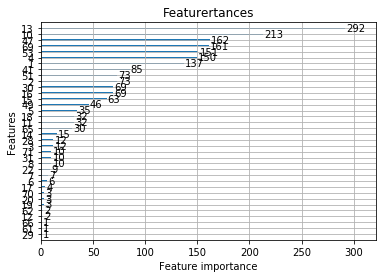

In [19]:
plt.figure(figsize=(12,6))
lgb.plot_importance(gbm)
plt.title("Featurertances")
plt.show()

画出训练结果...


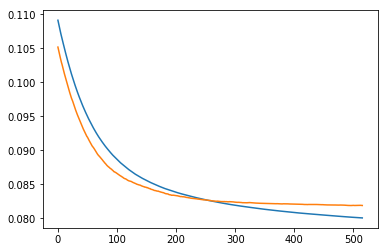

In [20]:
print('画出训练结果...')
plt.plot(range(len(evals_result['training']['l1'])),evals_result['training']['l1'])
plt.plot(range(len(evals_result['valid_1']['l1'])),evals_result['valid_1']['l1'])
plt.show()

### predict

In [21]:
# predict 因为我们刚训练的模型毕竟是61*2天前数据训练的模型，而我们希望用61天前数据训练的模型，照着test，往前推61天
# 但是这个也是冗余代码，其实这个数据就是valid_data
#train set
d1=test_fund_return.copy()
d11=test_fund_benchmark_return.copy()
d_index=test_index_return.copy()
d2=test_correlation.copy()
train_data=[]
for i in range(days):
    l=[]
    l=[d2.iloc[:,-1-i],d2.iloc[:,-1-61-i],d2.iloc[:,-1-61-20*1-i],d2.iloc[:,-1-61-20*2-i],d2.iloc[:,-1-61-20*3-i]]
    l.extend(c_indexs_corr(d1.iloc[:,-61-i-61:-i-61],[5,10,15,20,25,30,35,45,61]))
    l.extend(c_indexs_corr(d11.iloc[:,-61-i-61:-i-61],[5,10,15,20,25,30,35,45,61]))
    l.extend(c_indexs_corr(d1.iloc[:,-61-i-61:-i-61]-d11.iloc[:,-61-i-61:-i-61],[5,10,15,20,25,30,35,45,61]))
    l.append(index_status(d_index.iloc[:,-61-i-61:-i-61]))
    df=pd.concat(l[:5],axis=1).reset_index()
    for c in l[5:-1]:
        df=df.merge(c,on='index',how='left')
    df=df.set_index('index')
    df.reset_index(drop=True, inplace=True)
    df=pd.concat([df,l[-1]],axis=1)
    df=pd.concat([df,pd.DataFrame(get_return_std_corr(d11.iloc[:,-61-i-61:-i-61])).T],axis=1)
    df=pd.concat([df,pd.DataFrame(get_return_std_corr(d1.iloc[:,-61-i-61:-i-61])).T],axis=1)
    df=pd.concat([df,f_corr(d2.iloc[:,:-1-61-i])],axis=1)
    df['dist1']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]).iloc[:,:-8],metric='correlation')
    df['dist2']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]).iloc[:,-8:],metric='correlation')
    df['dist3']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]-d11.iloc[:,-61-i-61:-i-61]).iloc[:,:-8],metric='correlation')
    df['dist4']=1-pdist(f_corr(d1.iloc[:,-61-i-61:-i-61]-d11.iloc[:,-61-i-61:-i-61]).iloc[:,-8:],metric='correlation')
#     df=pd.concat([df,find_cluster_distance(d1.iloc[:,:-i-61])],axis=1)
#     distances = pdist(d1.iloc[:,-61-i-61:-i-61].values, metric='euclidean')
#     df['dis'] = distances
#     df['index_coef_corr1']=index_coef(d_index.iloc[:,-61-i-61:-i-61],d1.iloc[:,-61-i-61:-i-61])
    df.columns=range(len(df.columns))
    train_data.append(df)
train_data=pd.concat(train_data,axis=0)

In [22]:
#打乱数据，训练，利用上面选好的参数和轮数
train_data=train_data.sample(frac=1)
# create dataset for lightgbm
lgb_train = lgb.Dataset(train_data.drop(0,axis=1), train_data.iloc[:,0],weight=[(1/abs(1.5-v)) for v in train_data.iloc[:,0]])
# lgb_eval = lgb.Dataset(valid_data.drop(0,axis=1), valid_data.iloc[:,0],weight=[(1/abs(1.5-v)) for v in valid_data.iloc[:,0]])
# specify your configurations as a dict
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=num_boost_round,
                valid_sets=[lgb_train],
                early_stopping_rounds=20)

Start training...
[1]	training's l1: 0.0945378
Training until validation scores don't improve for 20 rounds.
[2]	training's l1: 0.0942047
[3]	training's l1: 0.0938756
[4]	training's l1: 0.0935517
[5]	training's l1: 0.0932329
[6]	training's l1: 0.0929198
[7]	training's l1: 0.0926112
[8]	training's l1: 0.0923102
[9]	training's l1: 0.0920125
[10]	training's l1: 0.0917196
[11]	training's l1: 0.0914278
[12]	training's l1: 0.0911443
[13]	training's l1: 0.0908507
[14]	training's l1: 0.0905624
[15]	training's l1: 0.0902822
[16]	training's l1: 0.090019
[17]	training's l1: 0.0897562
[18]	training's l1: 0.0894928
[19]	training's l1: 0.0892247
[20]	training's l1: 0.0889745
[21]	training's l1: 0.0887149
[22]	training's l1: 0.08847
[23]	training's l1: 0.0882305
[24]	training's l1: 0.0879905
[25]	training's l1: 0.0877565
[26]	training's l1: 0.0875267
[27]	training's l1: 0.0872974
[28]	training's l1: 0.0870745
[29]	training's l1: 0.0868422
[30]	training's l1: 0.0866181
[31]	training's l1: 0.0863983
[3

[272]	training's l1: 0.0707843
[273]	training's l1: 0.070769
[274]	training's l1: 0.0707544
[275]	training's l1: 0.0707387
[276]	training's l1: 0.0707239
[277]	training's l1: 0.0707123
[278]	training's l1: 0.0706956
[279]	training's l1: 0.0706816
[280]	training's l1: 0.0706691
[281]	training's l1: 0.0706552
[282]	training's l1: 0.0706417
[283]	training's l1: 0.0706268
[284]	training's l1: 0.0706111
[285]	training's l1: 0.070597
[286]	training's l1: 0.0705825
[287]	training's l1: 0.0705696
[288]	training's l1: 0.0705535
[289]	training's l1: 0.0705348
[290]	training's l1: 0.0705203
[291]	training's l1: 0.0705067
[292]	training's l1: 0.0704886
[293]	training's l1: 0.0704757
[294]	training's l1: 0.0704645
[295]	training's l1: 0.070452
[296]	training's l1: 0.0704389
[297]	training's l1: 0.0704265
[298]	training's l1: 0.0704146
[299]	training's l1: 0.0704021
[300]	training's l1: 0.0703851
[301]	training's l1: 0.0703714
[302]	training's l1: 0.0703594
[303]	training's l1: 0.0703465
[304]	train

In [23]:
print('Start predicting...')
y_pred = gbm.predict(test_df.values, num_iteration=gbm.best_iteration)
y_pred

Start predicting...


array([0.84832288, 0.7501522 , 0.73763672, ..., 0.64373057, 0.83726125,
       0.75197965])

In [24]:
len(y_pred)

261003

In [25]:
# pd.DataFrame({'id':test_correlation.index,'value':[math.tanh(i) for i in y_pred]}).to_csv('%s/lgbm_valid_data1_overfit_1029.csv' % PATH,index=False)
pd.DataFrame({'id':test_correlation.index,'value':y_pred}).to_csv('%s/1108_lgbm_valid_data2_jump_validate_简单版特征.csv' % PATH,index=False)